## NYC Neighborhood School Quality Metric: 

# NYC Neighborhood Residential Real Estate Analysis
### Applying Data Science Tools to  

    Josh Grasso | joshgrasso@gmail.com

Which NYC neighborhoods are the next great residential real estate investment and development stories? 

   



### Neighborhood School Quality: Measured by NYC Department of Education Math Test Scores
The goal here is to produce a metric for each neighborhood in NYC, which captures information about the desirability of the schools in that neighborhood. School selection is a prominent factor for all residents and families in deciding where to live or buy a home, including in NYC. NYC school enrollment, for both public and charter schools, is based on zoning. From InsideSchools.org, a resource for parents: "Starting in kindergarten, your child is eligible to attend a school based on your home address, often referred to as your "zoned" school. The city is divided into 32 school districts, and most districts are divided into several dozen individual school zones."

There are a handful of datasets made available by the NYC Department of Education which could be used to benchmark school quality and desirability. I chose scores on the Math section of a standardized test, administered to all Elementary and Middle-school aged students across NYC. These standardized tests began to be administered in 2013 when NY moved to Common Core Learning Standards: "The New York State P-12 Common Core Learning Standards (CCLS) are internationally-benchmarked and evidence-based standards." The data for all students in NYC public and charter schools, in grades 3 through 8, are aggregated at the school-level and are available for each year, from 2013 to 2019. There are average Math scores for over 1,300 schools in NYC, 1,118 public schools and 191 charter schools. 

My assumption is that Elementary school quality has a stronger influence on residential purchase decisions than later grades - for example High School. Also, I chose Math scores instead of English scores, and instead of an average of the two subjects/scores. In the event the Math and English scores were not strongly correlated, I'm biased as an engineer - and would have deferred to Math scores anyhow. 

There are two data sets for School Math Test scores, one for Public schools and one for Charter schools. This data is then mapped to the Department of Education’s definition of neighborhoods, termed Neighborhood Tabulation Areas (or NTA’s) based on the unique identifier for each school – the District Borough Number (DBN). There are a total of 195 NTA's. Finally, the NTA is mapped to the Neighborhood names used in the rest of the analysis, of which there are 306 distinct neighborhoods. It ends up being the case that one NTA may equate to multiple neighborhoods, as we define in the analysis. To rank the schools, and then the neighborhoods in terms of school quality, first the percentile rank for math test score results for each school is calculated for each year. The average of all years (2013 through 2019) is used as the average for each school, and the neighborhood metric is an average of each of these percentile values for each of the schools in that neighborhood. The final distribution of average percentiles across schools is very close to uniform – which is important in the analysis – a bell curve distribution would have presented a challenge in distinguishing one neighborhood from another in a regression.  

Private schools are omitted from the analysis, at this point. There isn’t uniform test data for private schools available from the sources I found. Also it’s not clear if zoning has any effect on private school attendance – at least in the same way as it does for public and charter schools. The lack of private schools in the analysis can produce some biases – such as in Manhattan were the relative quality of public schools in one neighborhood vs. another may have less of an impact on relative value of single family residences – if a meaningful amount of home buyers send their children to private schools anyhow. 

Finally, the average annual change in school percentile rank is calculated by fitting a linear regression to the full dataset for each individual school. This will be used to build a "momentum" metric for each neighborhood - to be used alongside a measure of "value" in determining which neighborhoods look most compelling from an investment perspective. A neighborhood with strong price growth and improving school quality is can differentiate it from other neighborhoods with less favorable trends.

#### Key Resources:
* NYC Elementary & Middle School Math Test Results, DOE & Charter School, 2013 - 2019:
    * https://infohub.nyced.org/reports/academics/test-results
* NYC Elementary School Enrollment Guide:
    * https://insideschools.org/elementary

#### Additional Research: 
* Add Private Schools:
    * https://www.isaagny.org/school-affiliates-directory/searchable-directory
    * https://www.niche.com/about/data/
    * https://nces.ed.gov/surveys/pss/privateschoolsearch/


In [3]:
import numpy as np
import pandas as pd
import requests

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')  
sns.set()

from datetime import datetime
today = datetime.now()
month,day,year = today.month,today.day,today.year

In [4]:
from pathlib import Path
home_path = Path.home() / 'Jupyter' / 'Real_Estate'

### Neighborhood School Quality Metric: Math Test Scores for Grades 3 - 8

There are a handful of datasets made available by the NYC Department of Education which could be used to benchmark school quality and desirability. I chose scores on the Math section of a standardized test, administered to all Elementary and Middle-school aged students across NYC. These standardized tests began to be administered in 2013 when NY moved to Common Core Learning Standards: "The New York State P-12 Common Core Learning Standards (CCLS) are internationally-benchmarked and evidence-based standards." The data is available for each year, from 2013 to 2019, for all students in NYC public and charter schools, in grades 3 through 8, aggregated at the school-level. There are Math scores for over 1,300 schools in NYC, 1,118 public schools and 191 charter schools. 


In [5]:
# School Quality: 
# Import NYC Public and Charter School Math Test Score Results
# Source: https://infohub.nyced.org/reports/academics/test-results

# The data is also available at the link below. 
# However, downloading the data as a JSON through the API link, only provided a portion of the full data set. 
# Source: https://data.cityofnewyork.us/Education/2013-2019-Math-Test-Results-School-SWD-Ethnicity-G/74ah-8ukf

local_path = home_path / 'Math_Scores.xlsx'
math_xls_df = pd.read_excel(local_path, sheet_name='All', header=0)


In [6]:
math_xls_df.head(2)

,Unnamed: 0,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M01532013All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,277.778,16,59.2593,11,40.7407,0,0,0,0,0,0
1,01M01532014All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,286.389,6,33.3333,9,50,2,11.1111,1,5.55556,3,16.6667


In [7]:
# Charter School Test Scores
# Source: https://infohub.nyced.org/reports/academics/test-results

local_path = home_path / 'Charter_Scores.xlsx'
charter_xls_df = pd.read_excel(local_path, sheet_name='Math', header=0)


In [8]:
charter_xls_df.head(2)

,Unnamed: 0,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,84K03732015All Students,84K037,BEGINNING WITH CHILDREN CHARTER SCHOOL II,3,2015,All Students,44,320.864,4,9.09091,14,31.8182,13,29.5455,13,29.5455,26,59.0909
1,84K03732016All Students,84K037,BEGINNING WITH CHILDREN CHARTER SCHOOL II,3,2016,All Students,52,330.212,2,3.84615,10,19.2308,19,36.5385,21,40.3846,40,76.9231


In [9]:
# math_xls_df.columns == charter_xls_df.columns  # True
all_math_df = math_xls_df.append(charter_xls_df).reset_index(drop=True)

In [10]:
all_math_df.head(5)

,Unnamed: 0,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M01532013All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,277.778,16,59.2593,11,40.7407,0,0,0,0,0,0
1,01M01532014All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,286.389,6,33.3333,9,50,2,11.1111,1,5.55556,3,16.6667
2,01M01532015All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,17,279.588,10,58.8235,4,23.5294,2,11.7647,1,5.88235,3,17.6471
3,01M01532016All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2016,All Students,21,274.81,13,61.9048,4,19.0476,4,19.0476,0,0,4,19.0476
4,01M01532017All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2017,All Students,29,301.552,8,27.5862,9,31.0345,7,24.1379,5,17.2414,12,41.3793


In [11]:
len(math_xls_df['DBN'].unique())

1118

In [12]:
len(charter_xls_df['DBN'].unique())

191

In [13]:
len(all_math_df['DBN'].unique())

1309

In [14]:
# Calculate Percentiles:
math_clean_df = all_math_df[all_math_df['Grade'] == 'All Grades'].reset_index(drop=True)
math_clean_df = math_clean_df.drop(index=1264)  
# ValueError: Unable to parse string "s" at position 1264
# About the data: In order to comply with regulations of the Family Educational Rights and Privacy Act (FERPA) 
# on public reporting of education outcomes, groups with 5 or fewer tested students are suppressed with an “s”.
# Source: https://data.cityofnewyork.us/Education/2013-2019-Math-Test-Results-School-SWD-Ethnicity-G/74ah-8ukf

math_clean_df['Mean Scale Score'] = pd.to_numeric(math_clean_df['Mean Scale Score'])

math_clean_df = pd.pivot_table(math_clean_df, values='Mean Scale Score', index='DBN', columns='Year', 
                           aggfunc='mean', fill_value=np.nan)
# math_clean_df[math_clean_df.index.duplicated(keep=False)]  # None

In [15]:
math_clean_df

Year,2013,2014,2015,2016,2017,2018,2019
DBN,,,,,,,
01M015,276.394379,278.031738,278.293091,285.673065,306.536224,606.596985,605.957153
01M019,300.500000,307.855774,317.700012,316.075256,315.428558,602.955078,600.187500
01M020,295.536804,297.768250,292.905365,296.718170,291.956726,593.075500,595.597961
01M034,300.446960,297.772736,294.807098,291.080322,290.646240,588.389160,586.479370
01M063,286.419342,300.735840,300.040008,311.041656,308.523071,602.250000,594.730774
...,...,...,...,...,...,...,...
84X705,296.145325,302.211212,300.351959,305.417206,306.946503,602.686646,601.661865
84X706,302.260254,305.920563,312.170319,317.463593,318.359528,605.712219,609.585938
84X717,322.783661,323.800934,320.311005,323.910461,319.939392,608.284363,615.690491


In [16]:
math_clean_df[math_clean_df.isnull().any(axis=1)]

Year,2013,2014,2015,2016,2017,2018,2019
DBN,,,,,,,
02M177,NaN,NaN,336.925934,333.223083,328.145355,609.794861,617.157532
02M267,NaN,319.916656,324.959473,335.945740,338.186737,618.038696,621.163757
02M281,NaN,NaN,NaN,NaN,325.916656,614.034485,621.565247
02M297,NaN,NaN,NaN,NaN,NaN,606.652405,607.161316
02M340,NaN,NaN,NaN,NaN,NaN,609.864868,610.662353
...,...,...,...,...,...,...,...
84X579,NaN,NaN,NaN,NaN,NaN,NaN,617.389832
84X585,NaN,NaN,NaN,NaN,NaN,603.047241,600.713135
84X592,NaN,NaN,NaN,NaN,NaN,NaN,616.974365


In [17]:
# math_clean_df.isnull().sum()
math_clean_df.isnull().T.sum().sort_values(ascending=False).value_counts()

0    1143
1      42
2      31
4      28
6      25
3      22
5      18
dtype: int64

In [18]:
# Percentiles: 
math_percentiles_df = math_clean_df.rank(axis=0, pct=True)
math_percentiles_df

Year,2013,2014,2015,2016,2017,2018,2019
DBN,,,,,,,
01M015,0.092657,0.113924,0.115954,0.244750,0.587678,0.739875,0.706422
01M019,0.569930,0.627004,0.772204,0.721325,0.703002,0.646417,0.530581
01M020,0.474650,0.454852,0.381579,0.443457,0.350711,0.333333,0.382263
01M034,0.569056,0.455696,0.414474,0.340872,0.329384,0.153427,0.074924
01M063,0.300699,0.508861,0.504112,0.651858,0.612954,0.623053,0.348624
...,...,...,...,...,...,...,...
84X705,0.490385,0.535865,0.509868,0.573506,0.597946,0.634735,0.574159
84X706,0.603147,0.589873,0.688322,0.740711,0.738547,0.718069,0.789755
84X717,0.884615,0.849789,0.801809,0.819063,0.763823,0.775701,0.906728


In [19]:
# School Quality Metric: Use the average percentile for all of the years available
# Incorporate as much of the data as is available
# Come back to the change from 2013 to 2019 - to get a sense of which schools/neighborhoods are improving
school_percentile_avg_df = (math_percentiles_df.apply(lambda x: np.mean(x), axis=1)
                               .to_frame(name='Avg_Percentile')
                               .sort_values(by='Avg_Percentile').reset_index())

In [20]:
school_percentile_avg_df

,DBN,Avg_Percentile
0,09X593,0.000765
1,09X350,0.006475
2,09X594,0.006881
3,84M279,0.011651
4,10X207,0.015291
...,...,...
1304,01M539,0.993771
1305,30Q580,0.994576
1306,03M334,0.996265
1307,84M523,0.996706


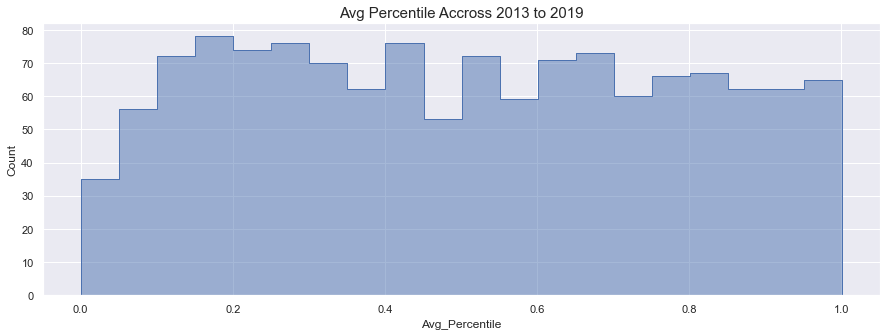

In [21]:
# Plot it first, they might all be stacked together in the middle (50%)
plt.figure(figsize=(15,5))
ax = sns.histplot(data=school_percentile_avg_df, x="Avg_Percentile", 
                  binwidth=0.05, alpha=0.5, element="step"); # color=u'b'
plt.title("Avg Percentile Accross 2013 to 2019", fontsize=15);

In [22]:
# What Elementary School am I zoned for? 
# PS 107 John W. Kimball
# Source: https://schoolsearch.schools.nyc/
school_percentile_avg_df[school_percentile_avg_df['DBN'] == '15K107']

,DBN,Avg_Percentile
1230,15K107,0.937733


### DBN to NTA: NTA to Neighborhoods:

As shown in the data above, Math test results are aggregated at the school-level. The District-Borough-Number (DBN) column provides the unique identification code for each school in NYC. The metric/column that I'll use to benchmark school quality is the "Mean Scale Score," which is the "average of total students tested." 

For our real estate analysis, we need to build a metric of the school quality in each neighborhood in NYC. Thus, we will use this school-level data (by DBN), and map it to each neighborhood. As you can see above, there is no location information in this table - so we need to add it. 

The data below provides location information for each school - and is made available by NYC Department of Education. First, note that there are several "definitions" of NYC neighborhoods, defined and used by the different govt. departments in NYC (Education, Planning, Finance). The definition used here is the Neighborhood Tabulation Areas (NTA). There are 195 NTAs. The definition we are using to define neighborhoods in our analysis of real estate prices has over 300 neighborhoods. Thus, we will need to map NTA's to the final definition we are using. Also note that we are supplementing the school location data below with the comprehensive NTA dataset - to add the information on which Borough each neighborhood/NTA is located.


In [23]:
# School DBN to NTA: 
# This data has the DBN (shown here as ATS) which is unique to the school, and maps to test/performace data
# It also has NTA data, which can be used to map to the NYC Neighborhood

#  Neighborhood Tabulation Areas (NTA)
# Source: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page

# School Locations: 
school_locations_csv_url = 'https://data.cityofnewyork.us/api/views/i4ni-6qin/rows.csv?accessType=DOWNLOAD'
# Source: https://data.cityofnewyork.us/Education/2015-2016-School-Locations/i4ni-6qin
# - also - : Source: https://data.cityofnewyork.us/Education/2018-2019-School-Locations/9ck8-hj3u

resp = requests.get(school_locations_csv_url)
local_path = home_path / 'School_Locations.csv'
with open(local_path, 'wb') as output:
    output.write(resp.content)
school_locations_df = pd.read_csv(local_path)

In [24]:
# Visualize: 
# school_locations_df.head().T

In [25]:
# Incl. Charter Schools?: # school_locations_df['managed_by_name'].unique()  # ['DOE', 'Charter'] Yes

school_locations_df = school_locations_df[['ATS SYSTEM CODE', 'LOCATION_NAME', 'LOCATION_CATEGORY_DESCRIPTION',
                                           'NTA', 'NTA_NAME', 'PRIMARY_ADDRESS_LINE_1', 'MANAGED_BY_NAME',
                                           'OPEN_DATE']].copy()
school_locations_df['ATS SYSTEM CODE'] = school_locations_df['ATS SYSTEM CODE'].str.rstrip()
school_locations_df['NTA_NAME'] = school_locations_df['NTA_NAME'].str.rstrip()
school_locations_df = school_locations_df.rename(columns={'ATS SYSTEM CODE': 'ATS_SYSTEM_CODE'})

In [26]:
school_locations_df.head(2)

,ATS_SYSTEM_CODE,LOCATION_NAME,LOCATION_CATEGORY_DESCRIPTION,NTA,NTA_NAME,PRIMARY_ADDRESS_LINE_1,MANAGED_BY_NAME,OPEN_DATE
0,01M015,P.S. 015 Roberto Clemente,Elementary,MN28,Lower East Side,333 EAST 4 STREET,DOE,07/01/1904 12:00:00 AM
1,01M019,P.S. 019 Asher Levy,Elementary,MN22,East Village,185 1 AVENUE,DOE,07/01/1956 12:00:00 AM


In [27]:
len(school_locations_df['ATS_SYSTEM_CODE'].unique())

1836

In [28]:
len(school_locations_df['NTA'].unique())

190

In [29]:
school_percentile_locations_df = school_percentile_avg_df.copy()
school_percentile_locations_df['NTA'] = school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['NTA'])
school_percentile_locations_df['NTA_NAME'] = school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['NTA_NAME'])
school_percentile_locations_df['MANAGED_BY_NAME'] = (school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['MANAGED_BY_NAME']))
school_percentile_locations_df['LOCATION_NAME'] = (school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['LOCATION_NAME']))
school_percentile_locations_df['LOCATION_CATEGORY_DESCRIPTION'] = (school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['LOCATION_CATEGORY_DESCRIPTION']))
school_percentile_locations_df['PRIMARY_ADDRESS_LINE_1'] = school_percentile_locations_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['PRIMARY_ADDRESS_LINE_1'])

In [30]:
school_percentile_locations_df.head(2)

,DBN,Avg_Percentile,NTA,NTA_NAME,MANAGED_BY_NAME,LOCATION_NAME,LOCATION_CATEGORY_DESCRIPTION,PRIMARY_ADDRESS_LINE_1
0,09X593,0.000765,NaN,NaN,NaN,NaN,NaN,NaN
1,09X350,0.006475,BX14,East Concourse-Concourse Village,DOE,New Directions Secondary School,Secondary School,240 EAST 172 STREET


In [31]:
missing_locations_df = school_percentile_locations_df[school_percentile_locations_df['NTA'].isna()]
len(missing_locations_df['DBN'].unique())

27

### Missing School Locations:
There are 27 schools, from the Math scores data set, which have unknown locations given that the School locations data set did not contain these schools. Recall that we previously had over 1,300 locations, thus 27 represents 2% of the schools. 

Below, let's parse the DBN, to extract more information about the missing schools.

The District-Borough-Number


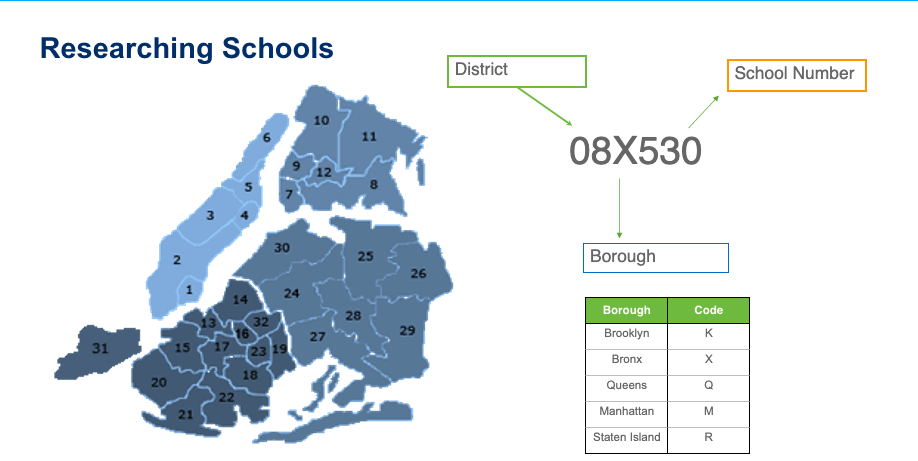

In [32]:
from IPython.display import Image
from pathlib import Path
print("The District-Borough-Number")
Image(filename= home_path / 'NYC_DOE_DBN.png') 
# Source: https://teachnyc.zendesk.com/hc/en-us/articles/360053601831-What-is-a-DBN-District-Borough-Number-#:~:text=The%20DBN%20or%20District%20Borough,has%20a%20District%20Borough%20Number.

In [33]:
dnb_dict = {'Brooklyn': 'K', 
            'Queens': 'Q', 
            'Bronx': 'X', 
            'Manhattan': 'M', 
            'Staten_Island': 'R'}

In [34]:
# Parse DBN's to better understand Missing School Locations
# '(\d+)(K?X?Q?M?R?)(\d+)'
import re
dbn_regex = re.compile('(\d+)(K?X?Q?M?R?)(\d+)')  # Resource: https://regex101.com/
missing_schools_list = [] 
for missing_dbn in missing_locations_df['DBN'].unique():
    _regex_match = re.search(dbn_regex, missing_dbn)
    if _regex_match is not None:
        district, borough, school_number = _regex_match.groups()
        missing_schools_list.append({'District': district, 
                                     'Borough': borough, 
                                     'School_Number': school_number})
    else:
        pass

missing_schools_df = pd.DataFrame(missing_schools_list)
# Switch Keys/Values in dnb_dict
missing_schools_df = missing_schools_df.replace(dict((v,k) for k,v in dnb_dict.items()))

In [35]:
missing_schools_df.head(2)

,District,Borough,School_Number
0,09,Bronx,593
1,09,Bronx,594


In [36]:
missing_schools_df['Borough'].value_counts()

Brooklyn     10
Bronx         8
Queens        5
Manhattan     4
Name: Borough, dtype: int64

In [37]:
missing_schools_df['District'].value_counts()

84    19
09     2
19     1
02     1
25     1
07     1
22     1
16     1
Name: District, dtype: int64

### District 84 is for Charter Schools:
* Source: https://infohub.nyced.org/reports/school-quality/charter-school-renewal-reports

Almost all of the missing school location data is from Charter schools. Sadly, I can't check the Open Date b/c that data is NaN. Let's move on, rather than trying a work arround for the missing schools. 


In [38]:
# Drop Schools without location data:

school_percentile_locations_df = school_percentile_locations_df[school_percentile_locations_df['NTA'].notna()]


In [39]:
school_percentile_locations_df['MANAGED_BY_NAME'].unique()

array(['DOE', 'Charter'], dtype=object)

In [40]:
# Analyze Grade Levels: Before I start filtering the data (for only 'All Grades')
# Question: Is admission at Secondary Schools based on residence? 

location_category_description_list = ['Elementary', 'K-8', 'Secondary School',
                                      'Junior High-Intermediate-Middle', 'High school',
                                      'K-12 all grades', 'Early Childhood', 'Ungraded']
school_institution_dict = {}
for institution in ['DOE', 'Charter']:
    school_categories_dict = dict.fromkeys(location_category_description_list)
    for category in location_category_description_list:
        _filtered = school_percentile_locations_df[school_percentile_locations_df['MANAGED_BY_NAME']  == institution]
        school_categories_dict[category] = (_filtered[_filtered['LOCATION_CATEGORY_DESCRIPTION'] == category]
                                            ['NTA'].unique().shape[0])
    school_institution_dict[institution] = school_categories_dict
# school_locations_df['MANAGED_BY_NAME'].unique()  # 
pd.DataFrame.from_dict(school_institution_dict, orient='index')


,Elementary,K-8,Secondary School,Junior High-Intermediate-Middle,High school,K-12 all grades,Early Childhood,Ungraded
DOE,181,85,59,129,1,4,3,0
Charter,36,31,19,11,0,26,1,0


In [41]:
# Inspect the one High School in the dataset:
# school_percentile_locations_df[school_percentile_locations_df['LOCATION_CATEGORY_DESCRIPTION'] == 'High school']

In [42]:
# School NTA:
# Use to add Borough to NTA data, then to map to neighborhoods: 
# Source: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page

nta_json_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/NYC_Neighborhood_Tabulation_Areas/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
resp = requests.get(nta_json_url)
nta_json = resp.json()

nta_property_list = []
for nta_property in nta_json['features']:
    nta_dict = dict.fromkeys(['BoroName', 'NTACode', 'NTAName'])
    for key in nta_dict:
        nta_dict[key] = nta_property['properties'][key]
    nta_property_list.append(nta_dict)

nta_df = pd.DataFrame(nta_property_list)
nta_df['BoroName'] = nta_df['BoroName'].replace({'Staten Island': 'Staten_Island'})


In [43]:
nta_df  # [['BoroName', 'NTAName', 'NTACode']]

,BoroName,NTACode,NTAName
0,Brooklyn,BK88,Borough Park
1,Queens,QN51,Murray Hill
2,Queens,QN27,East Elmhurst
3,Queens,QN07,Hollis
4,Brooklyn,BK25,Homecrest
...,...,...,...
190,Brooklyn,BK93,Starrett City
191,Brooklyn,BK73,North Side-South Side
192,Brooklyn,BK90,East Williamsburg
193,Manhattan,MN21,Gramercy


In [44]:
# Didn't work: school_percentile_locations_df['Borough'] = school_percentile_locations_df['NTA'].map(school_locations_df.set_index('NTA')['Borough'])
school_percentile_locations_df['Borough'] = school_percentile_locations_df['NTA'].map(nta_df.set_index('NTACode')['BoroName'])


In [45]:
school_percentile_locations_df

,DBN,Avg_Percentile,NTA,NTA_NAME,MANAGED_BY_NAME,LOCATION_NAME,LOCATION_CATEGORY_DESCRIPTION,PRIMARY_ADDRESS_LINE_1,Borough
1,09X350,0.006475,BX14,East Concourse-Concourse Village,DOE,New Directions Secondary School,Secondary School,240 EAST 172 STREET,Bronx
3,84M279,0.011651,MN11,Central Harlem South,Charter,The Opportunity Charter School,Secondary School,240 WEST 113 STREET,Manhattan
4,10X207,0.015291,BX29,Spuyten Duyvil-Kingsbridge,DOE,P.S. 207,Early Childhood,3030 GODWIN TERRACE,Bronx
5,14K586,0.015439,BK90,East Williamsburg,DOE,Lyons Community School,Secondary School,223 GRAHAM AVENUE,Brooklyn
6,06M328,0.017324,MN36,Washington Heights South,DOE,M.S. 328 - Manhattan Middle School for Scientific,Junior High-Intermediate-Middle,401 WEST 164 STREET,Manhattan
...,...,...,...,...,...,...,...,...,...
1304,01M539,0.993771,MN28,Lower East Side,DOE,"New Explorations into Science, Technology and ...",K-12 all grades,111 COLUMBIA STREET,Manhattan
1305,30Q580,0.994576,QN68,Queensbridge-Ravenswood-Long Island City,DOE,Baccalaureate School for Global Education,Secondary School,34-12 36 AVENUE,Queens
1306,03M334,0.996265,MN12,Upper West Side,DOE,The Anderson School,K-8,100 WEST 77 STREET,Manhattan
1307,84M523,0.996706,MN12,Upper West Side,Charter,Success Academy Charter School - Upper West,Elementary,145 WEST 84 STREET,Manhattan


In [46]:
# Map NTA to Neighborhoods: 

# Neighborhoods Names
# https://www1.nyc.gov/site/planning/data-maps/open-data.page

neighborhood_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
resp = requests.get(neighborhood_url)
neighborhood_json = resp.json()

neighborhood_ids_list = []
neighborhood_details_list = []

for neighborhood_dict in neighborhood_json['features']:
    neighborhood_ids_list.append(neighborhood_dict['id']) 
    
    d = {}
    d['ID'] = neighborhood_dict['id']
    # Neighborhood instead of name? 
    d['Name'] = neighborhood_dict['properties']['Name']
    d['Borough'] = neighborhood_dict['properties']['Borough']
    d['Lat'] = neighborhood_dict['geometry']['coordinates'][1]
    d['Long'] = neighborhood_dict['geometry']['coordinates'][0]
    
    neighborhood_details_list.append(d)

neighborhood_df = pd.DataFrame.from_dict(neighborhood_details_list)
neighborhood_df['Borough'] = neighborhood_df['Borough'].replace({'Staten Island': 'Staten_Island'})


In [47]:
neighborhood_df

,ID,Name,Borough,Lat,Long
0,1,Wakefield,Bronx,40.894713,-73.847202
1,2,Co-op City,Bronx,40.874302,-73.829941
2,3,Eastchester,Bronx,40.887564,-73.827808
3,4,Fieldston,Bronx,40.895446,-73.905644
4,5,Riverdale,Bronx,40.890843,-73.912587
...,...,...,...,...,...
301,302,Stapleton,Staten_Island,40.626936,-74.077903
302,303,Rosebank,Staten_Island,40.615313,-74.069807
303,304,West Brighton,Staten_Island,40.631887,-74.107183
304,305,Grymes Hill,Staten_Island,40.624193,-74.087250


In [48]:
# Neighborhood vs. NTA
neighborhood_agg_df = neighborhood_df.groupby(['Borough','Name']).mean() 

nta_agg_df = nta_df.set_index(['BoroName', 'NTAName'])
# Test Duplicates: # nta_agg_df[nta_agg_df.index.duplicated()]
# nta_agg_df.index.to_list()

nta_neighborhood_intersection = set(neighborhood_agg_df.index.to_list()).intersection(nta_agg_df.index.to_list())
nta_neighborhood_diff = set(neighborhood_agg_df.index.to_list()).difference(nta_agg_df.index.to_list())

nta_neighborhood_dict = {}
nta_neighborhood_dict['Intersection'] = len(nta_neighborhood_intersection)
nta_neighborhood_dict['Difference'] = len(nta_neighborhood_diff)
nta_vs_neighborhood_df = pd.DataFrame(nta_neighborhood_dict, index=[0])
nta_vs_neighborhood_df

,Intersection,Difference
0,86,220


### Manually Build the Crosswalk from NTA to Neighborhood:

* Neighborhood Map: https://www1.nyc.gov/site/planning/data-maps/city-neighborhoods.page
* NTA Map: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/ntas.pdf

In [49]:
borough_list = ['Brooklyn', 'Queens', 'Bronx', 'Manhattan', 'Staten_Island']

In [50]:
_borough_search = 'Staten_Island'  # 'Manhattan'

# Neighborhoods & NTA's:  Which Neighborhoods overlap btw. Neighborhood and NTA's?
(set(neighborhood_agg_df.xs(_borough_search, level=0).index.to_list())
 .intersection(nta_df[['BoroName', 'NTAName', 'NTACode']].set_index(['BoroName', 'NTAName']).xs(_borough_search, level=0).index.to_list()))


{'Arden Heights', 'Great Kills', 'Port Richmond', 'Westerleigh'}

In [51]:
# Missing Neighborhoods:  Which Neighborhoods need to be mapped from NTA's?
print((set(neighborhood_agg_df.xs(_borough_search, level=0).index.to_list())
 .difference(nta_df[['BoroName', 'NTAName', 'NTACode']].set_index(['BoroName', 'NTAName']).xs(_borough_search, level=0).index.to_list())))


{'Greenridge', 'Graniteville', 'Arlington', 'Bloomfield', 'Huguenot', 'Rossville', 'Fox Hills', 'Richmond Valley', 'Shore Acres', 'Grymes Hill', 'Woodrow', 'New Brighton', 'Richmond Town', 'New Dorp Beach', 'Bulls Head', 'Butler Manor', 'Castleton Corners', 'Oakwood', 'Stapleton', 'Clifton', 'Willowbrook', 'Lighthouse Hill', 'Midland Beach', "Mariner's Harbor", 'Howland Hook', 'Travis', 'Elm Park', 'Manor Heights', 'Emerson Hill', 'Concord', 'South Beach', 'Port Ivory', 'Charleston', 'Grasmere', 'Tompkinsville', 'Park Hill', 'Eltingville', 'Sandy Ground', 'Randall Manor', 'Silver Lake', 'New Springville', 'Sunnyside', 'Todt Hill', 'West Brighton', 'Pleasant Plains', 'Old Town', 'Arrochar', 'Egbertville', 'Heartland Village', 'St. George', 'Rosebank', 'Grant City', 'Annadale', 'Chelsea', 'Tottenville', 'Bay Terrace', "Prince's Bay", 'New Dorp', 'Dongan Hills'}


In [52]:
# Missing NTS: Which NTA's need to be mapped to a Neighborhood?

print((set(nta_df[['BoroName', 'NTAName', 'NTACode']].set_index(['BoroName', 'NTAName']).xs(_borough_search, level=0).index.to_list())
 .difference(neighborhood_agg_df.xs(_borough_search, level=0).index.to_list())))


{'Old Town-Dongan Hills-South Beach', "Mariner's Harbor-Arlington-Port Ivory-Graniteville", 'park-cemetery-etc-Staten Island', 'West New Brighton-New Brighton-St. George', 'Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill', 'New Brighton-Silver Lake', 'Stapleton-Rosebank', 'Charleston-Richmond Valley-Tottenville', 'New Springville-Bloomfield-Travis', 'Rossville-Woodrow', 'Oakwood-Oakwood Beach', 'Grasmere-Arrochar-Ft. Wadsworth', 'Grymes Hill-Clifton-Fox Hills', 'New Dorp-Midland Beach', "Annadale-Huguenot-Prince's Bay-Eltingville"}


In [53]:
# Manually constructed Crosswalks: 

In [54]:
# Intersection: Staten Island
#{'Arden Heights', 'Great Kills', 'Port Richmond', 'Westerleigh'}

# Missing Neighborhoods: Staten Island
#{#'Annadale', #'Arlington', #'Arrochar', #'Bay Terrace', #'Bloomfield', #'Bulls Head', #'Butler Manor',
 #'Castleton Corners', #'Charleston', #'Chelsea', #'Clifton', #'Concord', #'Dongan Hills', #'Egbertville',
 #'Elm Park', #'Eltingville', #'Emerson Hill', #'Fox Hills', #'Graniteville', #'Grant City', #'Grasmere',
 #'Greenridge', #'Grymes Hill', #'Heartland Village', #'Howland Hook', #'Huguenot', #'Lighthouse Hill',
 #'Manor Heights', #"Mariner's Harbor", #'Midland Beach', #'New Brighton', #'New Dorp', #'New Dorp Beach',
 #'New Springville', #'Oakwood', #'Old Town', #'Park Hill', #'Pleasant Plains', #'Port Ivory', #"Prince's Bay",
 #'Randall Manor', #'Richmond Town', #'Richmond Valley', #'Rosebank', #'Rossville', #'Sandy Ground',
 #'Shore Acres', #'Silver Lake', #'South Beach', #'St. George', #'Stapleton', #'Sunnyside', #'Todt Hill',
 #'Tompkinsville', #'Tottenville', #'Travis', #'West Brighton', #'Willowbrook', #'Woodrow'}

# Unmatched NTAs: Staten Island
nta_to_neighborhood_staten_island_dict = {
    "Annadale-Huguenot-Prince's Bay-Eltingville":  ['Annadale', 'Eltingville', 'Huguenot', 
                                                    "Prince's Bay", 'Greenridge'],
    'Charleston-Richmond Valley-Tottenville':  ['Tottenville', 'Charleston', 'Richmond Valley', 'Butler Manor',
                                                'Sandy Ground', 'Pleasant Plains'],
    'Grasmere-Arrochar-Ft. Wadsworth':  ['Arrochar', 'Grasmere', 'Concord'],
    'Grymes Hill-Clifton-Fox Hills':  ['Grymes Hill', 'Silver Lake', 'Randall Manor', 'Sunnyside', 
                                       'Fox Hills', 'Park Hill'],
    "Mariner's Harbor-Arlington-Port Ivory-Graniteville":  ['Elm Park', "Mariner's Harbor", 'Arlington', 
                                                            'Port Ivory', 'Howland Hook', 'Graniteville'],
    'New Brighton-Silver Lake':  'West Brighton', 
    'New Dorp-Midland Beach':  ['New Dorp', 'New Dorp Beach', 'Grant City', 'Midland Beach'],
    'New Springville-Bloomfield-Travis':  ['Bloomfield', 'Chelsea', 'Travis', 'Bulls Head', 'Willowbrook', 
                                           'Manor Heights', 'New Springville'],
    'Oakwood-Oakwood Beach':  ['Oakwood','Richmond Town'],
    'Old Town-Dongan Hills-South Beach':  ['Dongan Hills', 'South Beach', 'Old Town'],
    'Rossville-Woodrow':  ['Rossville', 'Woodrow'],
    'Stapleton-Rosebank':  ['Tompkinsville', 'Stapleton', 'Clifton', 'Rosebank', 'Shore Acres'],
    'Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill':  ['Heartland Village', 'Lighthouse Hill',
                                                                  'Egbertville', 'Todt Hill', 'Emerson Hill'],
    'West New Brighton-New Brighton-St. George':  ['St. George', 'New Brighton'],
    'park-cemetery-etc-Staten Island': np.nan,
    # These have the key/name displayed as well as the other neighborhood
    'Great Kills': ['Great Kills', 'Bay Terrace'],
    'Westerleigh':  ['Westerleigh', 'Castleton Corners']
}


In [55]:
# Intersection: Queens
#{'Astoria', 'Auburndale', 'Bellerose', 'Cambria Heights', 'College Point', 'Corona', 'East Elmhurst',
# 'Elmhurst', 'Flushing', 'Forest Hills', 'Glendale', 'Hollis', 'Jackson Heights', 'Kew Gardens',
# 'Kew Gardens Hills', 'Laurelton', 'Maspeth', 'Middle Village', 'Murray Hill', 'North Corona',
# 'Oakland Gardens', 'Ozone Park', 'Queens Village', 'Queensboro Hill', 'Rego Park', 'Richmond Hill',
# 'Ridgewood', 'Rosedale', 'South Jamaica', 'South Ozone Park', 'St. Albans', 'Steinway', 'Whitestone',
# 'Woodhaven', 'Woodside'}

# Missing Neighborhoods: Queens
#{#'Arverne', #'Astoria Heights', #'Bay Terrace', #'Bayside', #'Bayswater', #'Beechhurst', #'Bellaire',
 #'Belle Harbor', #'Blissville', #'Breezy Point', #'Briarwood', #'Broad Channel', #'Brookville',
 #'Douglaston', #'Edgemere', #'Far Rockaway', #'Floral Park', #'Forest Hills Gardens', #'Fresh Meadows',
 #'Glen Oaks', #'Hammels', #'Hillcrest', #'Holliswood', #'Howard Beach', #'Hunters Point', #'Jamaica Center',
 #'Jamaica Estates', #'Jamaica Hills', #'Lefrak City', #'Lindenwood', #'Little Neck', #'Long Island City',
 #'Malba', #'Neponsit', #'Pomonok', #'Queensbridge', #'Ravenswood', #'Rochdale', #'Rockaway Beach',
 #'Rockaway Park', #'Roxbury', #'Somerville', #'Springfield Gardens', #'Sunnyside', #'Sunnyside Gardens',
 #'Utopia'}

# Unmatched NTAs: Queens
nta_to_neighborhood_queens_dict = {
    'Airport':  np.nan,
    'Baisley Park':  'Rochdale',
    'Bayside-Bayside Hills':  'Bayside',
    'Breezy Point-Belle Harbor-Rockaway Park-Broad Channel':  ['Breezy Point', 'Roxbury', 'Neponsit', 
                                                               'Belle Harbor', 'Rockaway Park', 
                                                               'Rockaway Beach', 'Broad Channel'],
    'Briarwood-Jamaica Hills':  ['Briarwood', 'Jamaica Hills'],
    'Douglas Manor-Douglaston-Little Neck':  ['Little Neck', 'Douglaston'],
    'East Flushing':  'Murray Hill',
    'Elmhurst-Maspeth':  'Woodside',
    'Far Rockaway-Bayswater':  ['Far Rockaway', 'Bayswater'],
    'Fresh Meadows-Utopia':  'Fresh Meadows',
    'Ft. Totten-Bay Terrace-Clearview':  'Bay Terrace',
    'Glen Oaks-Floral Park-New Hyde Park':  ['Glen Oaks', 'Floral Park'],
    'Hammels-Arverne-Edgemere':  ['Hammels', 'Arverne', 'Somerville', 'Edgemere'],
    'Hunters Point-Sunnyside-West Maspeth':  ['Hunters Point', 'Sunnyside Gardens', 'Sunnyside', 'Blissville'],
    'Jamaica':  'Jamaica Center',
    'Jamaica Estates-Holliswood':  ['Jamaica Estates', 'Holliswood'],
    'Lindenwood-Howard Beach':  ['Lindenwood', 'Howard Beach'],
    'Old Astoria':  'Astoria',
    'Pomonok-Flushing Heights-Hillcrest':  ['Pomonok', 'Utopia', 'Hillcrest'],
    'Queensbridge-Ravenswood-Long Island City':  ['Queensbridge', 'Ravenswood', 'Long Island City'],
    'Springfield Gardens North':  'Rochdale',
    'Springfield Gardens South-Brookville':  ['Springfield Gardens', 'Brookville'],
    'park-cemetery-etc-Queens': np.nan,
    # These have the key/name displayed as well as the other neighborhood
    'Steinway':  ['Steinway', 'Astoria Heights'],
    'Elmhurst':  ['Elmhurst', 'Lefrak City'],
    'Forest Hills':  ['Forest Hills', 'Forest Hills Gardens'],
    'Whitestone':  ['Whitestone', 'Malba', 'Beechhurst'],
    'Bellerose':  ['Bellerose', 'Bellaire']
}


In [56]:
# Intersection: Bronx
#{'Belmont', 'Bronxdale', 'Co-op City', 'East Tremont', 'Hunts Point', 'Kingsbridge Heights',
# 'Longwood', 'Mount Hope', 'Norwood', 'Parkchester', 'Pelham Parkway'}

# Missing Neighborhoods: Bronx
#{#'Allerton', #'Baychester', #'Bedford Park', #'Castle Hill', #'City Island', #'Claremont Village',
 #'Clason Point', #'Concourse', #'Concourse Village', #'Country Club', #'Eastchester', #'Edenwald',
 #'Edgewater Park', #'Fieldston', #'Fordham', #'High  Bridge', #'Kingsbridge', #'Melrose', #'Morris Heights',
 #'Morris Park', #'Morrisania', #'Mott Haven', #'Mount Eden', #'North Riverdale', #'Olinville', #'Pelham Bay',
 #'Pelham Gardens', #'Port Morris', #'Riverdale', #'Schuylerville', #'Soundview', #'Spuyten Duyvil',
 #'Throgs Neck', #'Unionport', #'University Heights', #'Van Nest', #'Wakefield', #'West Farms',
 #'Westchester Square', #'Williamsbridge', #'Woodlawn'}

# Unmatched NTAs: Bronx
nta_to_neighborhood_bronx_dict = {
    'Allerton-Pelham Gardens':  ['Allerton', 'Pelham Gardens'],
    'Bedford Park-Fordham North':  'Bedford Park',
    'Claremont-Bathgate':  'Claremont Village',
    'Crotona Park East':  'Claremont Village',
    'East Concourse-Concourse Village': ['Concourse', 'Concourse Village'],
    'Eastchester-Edenwald-Baychester':  ['Eastchester', 'Edenwald', 'Baychester'],
    'Fordham South':  'Fordham',
    'Highbridge':  'High  Bridge',
    'Melrose South-Mott Haven North':  'Melrose',
    'Morrisania-Melrose':  ['Claremont Village', 'Morrisania'],
    'Mott Haven-Port Morris':  ['Mott Haven', 'Port Morris'],
    'North Riverdale-Fieldston-Riverdale':  ['North Riverdale', 'Fieldston', 'Riverdale'],
    'Pelham Bay-Country Club-City Island':  ['Pelham Bay', 'Country Club', 'City Island'],
    'Rikers Island':  np.nan,
    'Schuylerville-Throgs Neck-Edgewater Park':  ['Schuylerville', 'Throgs Neck', 'Edgewater Park'],
    'Soundview-Bruckner':  'Soundview',
    'Soundview-Castle Hill-Clason Point-Harding Park':  ['Castle Hill', 'Clason Point', 'Soundview'],
    'Spuyten Duyvil-Kingsbridge':  ['Spuyten Duyvil', 'Kingsbridge'],
    'University Heights-Morris Heights':  ['Morris Heights', 'University Heights'],
    'Van Cortlandt Village':  'Kingsbridge',
    'Van Nest-Morris Park-Westchester Square':  ['Van Nest', 'Morris Park'],
    'West Concourse':  'Mount Eden',
    'West Farms-Bronx River':  'West Farms',
    'Westchester-Unionport':  ['Westchester Square', 'Unionport'],
    'Williamsbridge-Olinville':  ['Williamsbridge', 'Olinville'],
    'Woodlawn-Wakefield':  ['Woodlawn', 'Wakefield'],
    'park-cemetery-etc-Bronx': np.nan
}


In [57]:
# Intersection: Brooklyn
#{'Bath Beach', 'Bay Ridge', 'Borough Park', 'Brighton Beach', 'Brownsville', 'Canarsie', 'Clinton Hill',
# 'Dyker Heights', 'East New York', 'East Williamsburg', 'Erasmus', 'Flatbush', 'Flatlands', 'Fort Greene',
# 'Gravesend', 'Greenpoint', 'Homecrest', 'Madison', 'Midwood', 'Ocean Hill', 'Prospect Heights',
# 'Starrett City', 'Williamsburg', 'Windsor Terrace'}

# Missing Neighborhoods: Brooklyn
#{#'Bedford Stuyvesant', #'Bensonhurst', #'Bergen Beach', #'Boerum Hill', #'Broadway Junction',
 #'Brooklyn Heights', #'Bushwick', #'Carroll Gardens', #'City Line', #'Cobble Hill', #'Coney Island',
 #'Crown Heights', #'Cypress Hills', #'Ditmas Park', #'Downtown', #'Dumbo', #'East Flatbush', #'Fort Hamilton',
 #'Fulton Ferry', #'Georgetown', #'Gerritsen Beach', #'Gowanus', #'Highland Park', #'Kensington',
 #'Manhattan Beach', #'Manhattan Terrace', #'Marine Park', #'Mill Basin', #'Mill Island', #'New Lots',
 #'North Side', #'Ocean Parkway', #'Paerdegat Basin', #'Park Slope', #'Prospect Lefferts Gardens',
 #'Prospect Park South', #'Red Hook', #'Remsen Village', #'Rugby', #'Sea Gate', #'Sheepshead Bay',
 #'South Side', #'Sunset Park', #'Vinegar Hill', #'Weeksville', #'Wingate'}

# Unmatched NTAs: Brooklyn
nta_to_neighborhood_brooklyn_dict = {
     'Bedford': 'Bedford Stuyvesant',
     'Bensonhurst East':  'Bensonhurst',
     'Bensonhurst West':  'Bensonhurst',
     'Brooklyn Heights-Cobble Hill':  ['Fulton Ferry', 'Brooklyn Heights', 'Cobble Hill'],
     'Bushwick North':  'Bushwick',
     'Bushwick South':  'Bushwick',
     'Carroll Gardens-Columbia Street-Red Hook':  ['Carroll Gardens', 'Red Hook'],  # (Possibly Cobble Hill)
     'Crown Heights North':  ['Crown Heights', 'Weeksville'],
     'Crown Heights South':  'Prospect Lefferts Gardens',
     'Cypress Hills-City Line':  ['City Line', 'Cypress Hills', 'Highland Park'],
     'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill':  ['Boerum Hill', 'Dumbo', 'Vinegar Hill', 'Downtown'],
     'East Flatbush-Farragut':  'East Flatbush',
     'East New York (Pennsylvania Ave)':  'New Lots',
     'Georgetown-Marine Park-Bergen Beach-Mill Basin':  ['Bergen Beach', 'Georgetown', 'Mill Basin', 
                                                         'Mill Island', 'Marine Park'],
     'Kensington-Ocean Parkway':  'Kensington', 
     'North Side-South Side': 'Williamsburg',  # ['North Side', 'South Side'],
     'Ocean Parkway South':  'Ocean Parkway',
     'Park Slope-Gowanus':  ['Gowanus', 'Park Slope'],
     'Prospect Lefferts Gardens-Wingate':  ['Prospect Lefferts Gardens', 'Wingate'],
     'Rugby-Remsen Village':  ['Remsen Village', 'Rugby'],
     'Seagate-Coney Island':  ['Coney Island', 'Sea Gate'],
     'Sheepshead Bay-Gerritsen Beach-Manhattan Beach': ['Gerritsen Beach', 'Sheepshead Bay', 'Manhattan Beach'],
     'Stuyvesant Heights':  'Bedford Stuyvesant',
     'Sunset Park East': 'Sunset Park',
     'Sunset Park West': 'Sunset Park',
     'West Brighton':  'Brighton Beach',
     'park-cemetery-etc-Brooklyn': np.nan,
    # These have the key/name displayed as well as the other neighborhood
     'Ocean Hill':  ['Ocean Hill', 'Broadway Junction'],
     'Flatbush':  ['Flatbush', 'Ditmas Park', 'Prospect Park South'],
     'Bay Ridge':  ['Bay Ridge', 'Fort Hamilton'],
     'Midwood':  ['Midwood', 'Manhattan Terrace'],
     'Canarsie':  ['Canarsie', 'Paerdegat Basin']
}


In [58]:
# Intersection: Manhattan
# {'Chinatown', 'Clinton', 'East Village', 'Gramercy', 'Hamilton Heights', 'Lincoln Square',
# 'Lower East Side', 'Manhattanville', 'Morningside Heights', 'Upper West Side', 'West Village', 'Yorkville'}

# Missing Neighborhoods: Manhattan
#{#'Battery Park City', #'Carnegie Hill', #'Central Harlem', #'Chelsea', #'Civic Center', #'East Harlem',
 #'Financial District', #'Flatiron', #'Greenwich Village', #'Hudson Yards', #'Inwood', #'Lenox Hill',
 #'Little Italy', #'Manhattan Valley', #'Marble Hill', #'Midtown', #'Midtown South', #'Murray Hill',
 #'Noho', #'Roosevelt Island', #'Soho', #'Stuyvesant Town', #'Sutton Place', #'Tribeca', #'Tudor City',
 #'Turtle Bay', #'Upper East Side', #'Washington Heights'}

# Unmatched NTAs: Manhattan
nta_to_neighborhood_manhattan_dict = {
    'Battery Park City-Lower Manhattan':  ['Battery Park City', 'Financial District'],
    'Central Harlem North-Polo Grounds':  'Central Harlem',
    'Central Harlem South':  'Central Harlem',
    'East Harlem North':  'East Harlem',
    'East Harlem South':  'East Harlem',
    'Hudson Yards-Chelsea-Flatiron-Union Square':  ['Hudson Yards', 'Chelsea', 'Flatiron'],
    'Lenox Hill-Roosevelt Island':  ['Lenox Hill', 'Roosevelt Island'],
    'Marble Hill-Inwood':  ['Marble Hill', 'Inwood'],
    'Murray Hill-Kips Bay':  'Murray Hill', 
    'SoHo-TriBeCa-Civic Center-Little Italy':  ['Soho', 'Tribeca', 'Civic Center', 'Little Italy'],
    'Turtle Bay-East Midtown':  ['Turtle Bay', 'Sutton Place', 'Tudor City'],
    'Upper East Side-Carnegie Hill':  ['Upper East Side', 'Carnegie Hill'],
    'Washington Heights North':  'Washington Heights',
    'Washington Heights South':   'Washington Heights',
    'Midtown-Midtown South':  ['Midtown','Midtown South'],
    'Stuyvesant Town-Cooper Village':  'Stuyvesant Town',
    'park-cemetery-etc-Manhattan': np.nan,
    # These have the key/name displayed as well as the other neighborhood
    'West Village':  ['West Village', 'Greenwich Village'],
    'Upper West Side':  ['Upper West Side', 'Manhattan Valley'],
    'Chinatown':  ['Chinatown', 'Noho']
}


In [59]:
# Duplicate NTA column - to be changed into a list
borough_list = ['Brooklyn', 'Queens', 'Bronx', 'Manhattan', 'Staten_Island']
nta_to_neighborhood_list = [nta_to_neighborhood_brooklyn_dict, nta_to_neighborhood_queens_dict, 
                            nta_to_neighborhood_bronx_dict, nta_to_neighborhood_manhattan_dict, 
                            nta_to_neighborhood_staten_island_dict]
# Delete?: nta_to_neighborhood_dict = dict(zip(borough_list, nta_to_neighborhood_list))
#pd.DataFrame.from_dict(nta_to_neighborhood_dict).index.duplicated(keep=False).sum()  # 0

In [60]:
# Join each Borough dict into one dict:
nta_to_neighborhood_dict = {**nta_to_neighborhood_brooklyn_dict, **nta_to_neighborhood_queens_dict, 
                            **nta_to_neighborhood_bronx_dict, **nta_to_neighborhood_manhattan_dict, 
                            **nta_to_neighborhood_staten_island_dict}


In [61]:
# Complete Mapping:
school_percentile_locations_df['Neighborhood'] = school_percentile_locations_df['NTA_NAME']
school_percentile_locations_df['Neighborhood'] = [nta_to_neighborhood_dict.get(key,key) for key in school_percentile_locations_df['NTA_NAME']]
school_percentile_locations_df = school_percentile_locations_df.explode('Neighborhood')


In [62]:
school_percentile_locations_df

,DBN,Avg_Percentile,NTA,NTA_NAME,MANAGED_BY_NAME,LOCATION_NAME,LOCATION_CATEGORY_DESCRIPTION,PRIMARY_ADDRESS_LINE_1,Borough,Neighborhood
1,09X350,0.006475,BX14,East Concourse-Concourse Village,DOE,New Directions Secondary School,Secondary School,240 EAST 172 STREET,Bronx,Concourse
1,09X350,0.006475,BX14,East Concourse-Concourse Village,DOE,New Directions Secondary School,Secondary School,240 EAST 172 STREET,Bronx,Concourse Village
3,84M279,0.011651,MN11,Central Harlem South,Charter,The Opportunity Charter School,Secondary School,240 WEST 113 STREET,Manhattan,Central Harlem
4,10X207,0.015291,BX29,Spuyten Duyvil-Kingsbridge,DOE,P.S. 207,Early Childhood,3030 GODWIN TERRACE,Bronx,Spuyten Duyvil
4,10X207,0.015291,BX29,Spuyten Duyvil-Kingsbridge,DOE,P.S. 207,Early Childhood,3030 GODWIN TERRACE,Bronx,Kingsbridge
...,...,...,...,...,...,...,...,...,...,...
1306,03M334,0.996265,MN12,Upper West Side,DOE,The Anderson School,K-8,100 WEST 77 STREET,Manhattan,Upper West Side
1306,03M334,0.996265,MN12,Upper West Side,DOE,The Anderson School,K-8,100 WEST 77 STREET,Manhattan,Manhattan Valley
1307,84M523,0.996706,MN12,Upper West Side,Charter,Success Academy Charter School - Upper West,Elementary,145 WEST 84 STREET,Manhattan,Upper West Side
1307,84M523,0.996706,MN12,Upper West Side,Charter,Success Academy Charter School - Upper West,Elementary,145 WEST 84 STREET,Manhattan,Manhattan Valley


In [63]:
# Final Output: School Quality metric for each Neighborhood in NYC

final_school_percentile_avg_df = (school_percentile_locations_df.explode('Neighborhood')
                                  .groupby(['Borough', 'Neighborhood']).mean())


In [64]:
final_school_percentile_avg_df

Avg_Percentile
Borough       Neighborhood                 
Bronx         Allerton             0.373751
              Baychester           0.312059
              Bedford Park         0.203534
              Belmont              0.257055
              Bronxdale            0.313201
...                                     ...
Staten_Island Travis               0.612509
              West Brighton        0.342709
              Westerleigh          0.740048
              Willowbrook          0.612509
              Woodrow              0.784308

[301 rows x 1 columns]

In [65]:
final_school_percentile_avg_df['Avg_Percentile'].isna().sum()

0

In [246]:
# Save to CSV: 

final_school_percentile_avg_df.to_csv(path_or_buf= home_path / 'Neighborhood_School_Quality_Percentile_Avg.csv')


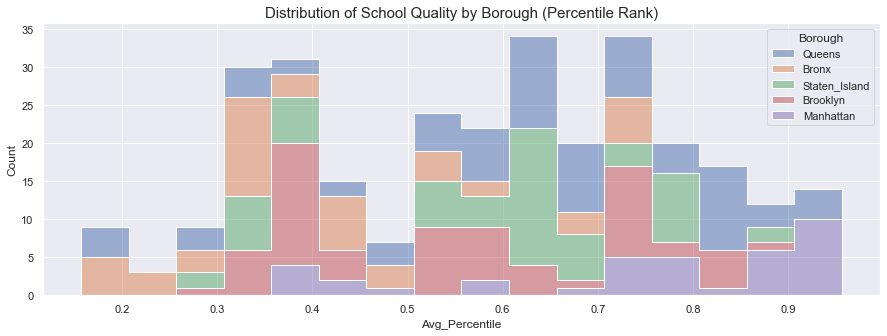

In [247]:
# Let's visualize the distribution of School Quality across each Borough:

plt.figure(figsize=(15,5))
ax = sns.histplot(data=final_school_percentile_avg_df.sort_values(by='Avg_Percentile').droplevel(1, axis=0), 
                  x="Avg_Percentile", hue='Borough',  multiple='stack', # 'stack',
                  stat='count', common_norm=False, # kde=True,  'density'
                  legend=True, #palette="viridis",  # stat='count'
                  binwidth=0.05, alpha=0.5, element='step'); # color=u'b' 
plt.title("Distribution of School Quality by Borough (Percentile Rank)", fontsize=15);


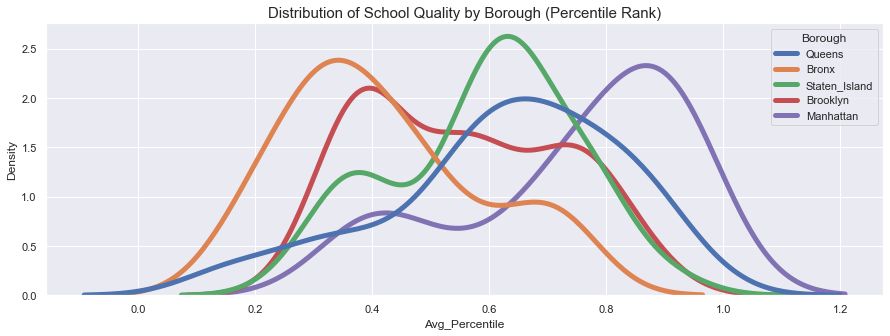

In [248]:
# Same data, just a different visualization: 

plt.figure(figsize=(15,5))
ax = sns.kdeplot(data=final_school_percentile_avg_df.sort_values(by='Avg_Percentile').droplevel(1, axis=0), 
                  x="Avg_Percentile", hue='Borough',  common_norm=False, legend=True, 
                 alpha=0.5, linewidth=5, );
plt.title("Distribution of School Quality by Borough (Percentile Rank)", fontsize=15);


### Some Thoughts on School Quality Across Boroughs:
* Manhattan, as is expected, has a greater concentratation of higher quality schools
* Staten Island seems to have most schools above the 50th percentile, which is better than I anticipated
* Brooklyn acutally has the hump of the distribution below the 50th percentile, as does the Bronx
* Meanwhile, Queens has the bulk of it's distribution above the 50th percentile

The 80th Percentile: 
Regarding the distribution of Borough schools ranked above the 80th percentile, Brooklyn and Staten Island have a similar percentage, Queens has a higher percentage, and the Bronx has a lower percentage. Manhattan has a majority of its schools above this threshold. It's an interesting area of further investigation - how do real estate prices compare between the Manhattan and outer-borough neighborhoods, in neighborhoods with school quality above the 80th percentile? And similarly, how do prices compare in Manhattan and outer-borough neighborhoods with school quality below the 80th percentile? 

### Trajectory of School Quality: Improving or Deteriorating

In addition the the average percentile ranking for each school, and each neighborhood, for all the data that is available from 2013 through 2019, let's also calculate which neighborhoods are on a positive trajectory. The real estate in a neighborhood can represent a value, and opportunity, if prices are below what can be explained by the regression across all of NYC using the factors of commute time, neighborhood quality, and school quality. Another important dimension to the analysis is if there is positive momentum: is the time-series of prices increasing, is there population growth, and is the school quality improving as well? 


In [249]:
math_percentiles_df

Year,2013,2014,2015,2016,2017,2018,2019
DBN,,,,,,,
01M015,0.092657,0.113924,0.115954,0.244750,0.587678,0.739875,0.706422
01M019,0.569930,0.627004,0.772204,0.721325,0.703002,0.646417,0.530581
01M020,0.474650,0.454852,0.381579,0.443457,0.350711,0.333333,0.382263
01M034,0.569056,0.455696,0.414474,0.340872,0.329384,0.153427,0.074924
01M063,0.300699,0.508861,0.504112,0.651858,0.612954,0.623053,0.348624
...,...,...,...,...,...,...,...
84X705,0.490385,0.535865,0.509868,0.573506,0.597946,0.634735,0.574159
84X706,0.603147,0.589873,0.688322,0.740711,0.738547,0.718069,0.789755
84X717,0.884615,0.849789,0.801809,0.819063,0.763823,0.775701,0.906728


In [66]:
def school_quailty_trajectory(series):
    _regression_values = series.dropna().values
    if len(_regression_values) >= 2:
        return np.polyfit(np.arange(len(_regression_values)), _regression_values, 1)[0]
    else:
        return 0

In [67]:
# Calculate Trajectory: Regression Slope

math_trajectory_df = math_percentiles_df.copy()
math_trajectory_df['Trajectory'] = math_trajectory_df.T.apply(lambda x: school_quailty_trajectory(x))
math_trajectory_df = math_trajectory_df.sort_values(by='Trajectory', ascending=False)

In [68]:
# Having missing years is causing outliers in the trajectory/slope parameter

math_trajectory_df

Year,2013,2014,2015,2016,2017,2018,2019,Trajectory
DBN,,,,,,,,
22K890,NaN,NaN,NaN,NaN,NaN,0.060748,0.503823,0.443075
84M295,NaN,NaN,NaN,NaN,0.182464,0.446262,0.611621,0.214578
24Q343,NaN,NaN,NaN,NaN,NaN,0.305296,0.500765,0.195469
84X460,NaN,NaN,NaN,0.077544,0.251975,0.418224,0.666667,0.193362
84K789,NaN,NaN,NaN,NaN,0.018957,0.428349,0.379205,0.180124
...,...,...,...,...,...,...,...,...
24Q211,NaN,NaN,NaN,NaN,0.711690,0.279595,0.464067,-0.123812
84K766,NaN,NaN,NaN,NaN,NaN,0.757788,0.610856,-0.146932
84X124,NaN,NaN,0.947368,0.918417,0.803318,0.558411,0.388379,-0.147798


In [69]:
# math_trajectory_df['Trajectory'].plot();

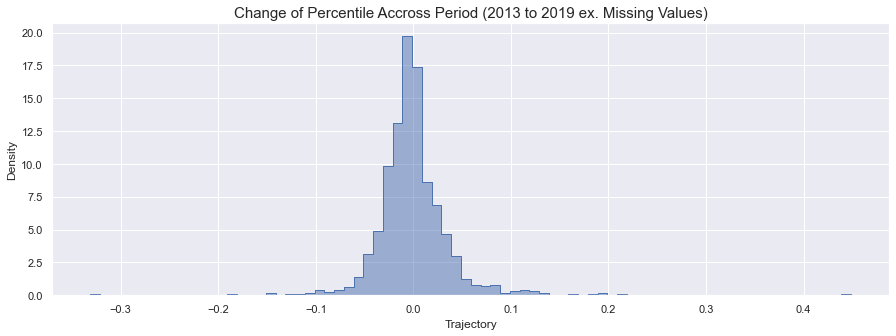

In [70]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=math_trajectory_df, x="Trajectory", stat='density',
                  binwidth=0.01, alpha=0.5, element="step"); # color=u'b'
plt.title("Change of Percentile Accross Period (2013 to 2019 ex. Missing Values)", fontsize=15);

In [71]:
# The outliers here are outside of a +/- 0.1 change in percentile rankings
# Let's check to what extent these are caused by missing years of data

#math_trajectory_df['Missing_Values'] = math_trajectory_df.T.apply(lambda x: x.isna().sum())
outliers_trajectory_df = (math_trajectory_df['Trajectory'].to_frame()
                          .join(math_trajectory_df.T.apply(lambda x: x.isna().sum()).rename('Missing_Values')))


In [72]:
# outliers_trajectory_df[outliers_trajectory_df['Missing_Values'] > 4]['Trajectory'].plot()

# outliers_trajectory_df[outliers_trajectory_df['Missing_Values'] <= 4]['Trajectory'].plot();

If a school has fewer than 4 years of data (missing 3 or more years), and is in the outer extremes of the distribution +/- 0.1 percentile change, then the outlier values are replaced with +/- 0.1. If however, the school is an outlier, as defined as a change greater-than or less than +/- 0.1, then the value remain. The lack of data is less of a factor.  

In [93]:
above_outliers_df = (outliers_trajectory_df[(outliers_trajectory_df['Trajectory'] >= 0.1) 
                                            & (outliers_trajectory_df['Missing_Values'] >= 3)])
above_outliers_df

,Trajectory,Missing_Values
DBN,,
22K890,0.443075,5
84M295,0.214578,4
24Q343,0.195469,5
84X460,0.193362,3
84K789,0.180124,4
84K807,0.159730,4
31R009,0.129558,4
84K879,0.127888,4
84X486,0.124603,5


In [94]:
below_outliers_df = (outliers_trajectory_df[(outliers_trajectory_df['Trajectory'] <= -0.1) 
                                            & (outliers_trajectory_df['Missing_Values'] >= 3)])
below_outliers_df

,Trajectory,Missing_Values
DBN,,
84X585,-0.106719,5
30Q329,-0.120945,4
24Q211,-0.123812,4
84K766,-0.146932,5
84X497,-0.181250,5
31R010,-0.331154,5


In [95]:
new_above_outliers_df = above_outliers_df.copy()
new_below_outliers_df = below_outliers_df.copy()

new_above_outliers_df['Trajectory'] = 0.1
new_below_outliers_df['Trajectory'] = -0.1

replace_outliers_df = new_above_outliers_df.append(new_below_outliers_df)
replace_outliers_df

,Trajectory,Missing_Values
DBN,,
22K890,0.1,5
84M295,0.1,4
24Q343,0.1,5
84X460,0.1,3
84K789,0.1,4
84K807,0.1,4
31R009,0.1,4
84K879,0.1,4
84X486,0.1,5


In [96]:
math_trajectory_df

Year,2013,2014,2015,2016,2017,2018,2019,Trajectory,Trajectory_Updated
DBN,,,,,,,,,
22K890,NaN,NaN,NaN,NaN,NaN,0.060748,0.503823,0.443075,0.443075
84M295,NaN,NaN,NaN,NaN,0.182464,0.446262,0.611621,0.214578,0.214578
24Q343,NaN,NaN,NaN,NaN,NaN,0.305296,0.500765,0.195469,0.195469
84X460,NaN,NaN,NaN,0.077544,0.251975,0.418224,0.666667,0.193362,0.193362
84K789,NaN,NaN,NaN,NaN,0.018957,0.428349,0.379205,0.180124,0.180124
...,...,...,...,...,...,...,...,...,...
24Q211,NaN,NaN,NaN,NaN,0.711690,0.279595,0.464067,-0.123812,-0.123812
84K766,NaN,NaN,NaN,NaN,NaN,0.757788,0.610856,-0.146932,-0.146932
84X124,NaN,NaN,0.947368,0.918417,0.803318,0.558411,0.388379,-0.147798,-0.147798


In [97]:
replace_outliers_df[replace_outliers_df.index.duplicated(keep=False)]

,Trajectory,Missing_Values
DBN,,


In [98]:
math_trajectory_df['Trajectory_Updated'] = math_trajectory_df['Trajectory']
math_trajectory_df['Trajectory_Updated'].update(replace_outliers_df['Trajectory'])

In [99]:
math_trajectory_df

Year,2013,2014,2015,2016,2017,2018,2019,Trajectory,Trajectory_Updated
DBN,,,,,,,,,
22K890,NaN,NaN,NaN,NaN,NaN,0.060748,0.503823,0.443075,0.100000
84M295,NaN,NaN,NaN,NaN,0.182464,0.446262,0.611621,0.214578,0.100000
24Q343,NaN,NaN,NaN,NaN,NaN,0.305296,0.500765,0.195469,0.100000
84X460,NaN,NaN,NaN,0.077544,0.251975,0.418224,0.666667,0.193362,0.100000
84K789,NaN,NaN,NaN,NaN,0.018957,0.428349,0.379205,0.180124,0.100000
...,...,...,...,...,...,...,...,...,...
24Q211,NaN,NaN,NaN,NaN,0.711690,0.279595,0.464067,-0.123812,-0.100000
84K766,NaN,NaN,NaN,NaN,NaN,0.757788,0.610856,-0.146932,-0.100000
84X124,NaN,NaN,0.947368,0.918417,0.803318,0.558411,0.388379,-0.147798,-0.147798


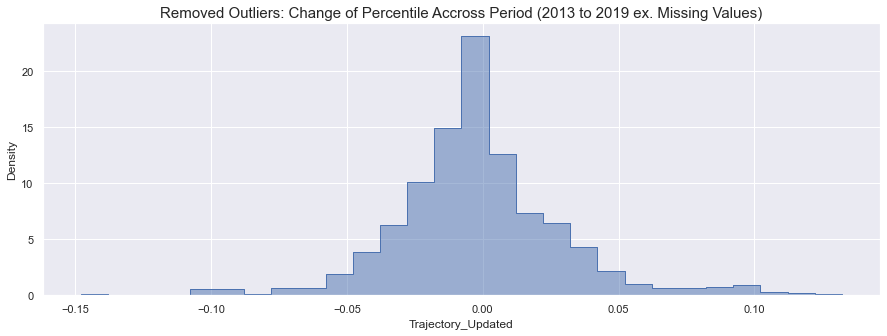

In [100]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=math_trajectory_df, x="Trajectory_Updated", stat='density',
                  binwidth=0.01, alpha=0.5, element="step"); # color=u'b'
plt.title("Removed Outliers: Change of Percentile Accross Period (2013 to 2019 ex. Missing Values)", fontsize=15);

In [101]:
math_trajectory_df.reset_index(drop=False)

Year,DBN,2013,2014,2015,2016,2017,2018,2019,Trajectory,Trajectory_Updated
0,22K890,NaN,NaN,NaN,NaN,NaN,0.060748,0.503823,0.443075,0.100000
1,84M295,NaN,NaN,NaN,NaN,0.182464,0.446262,0.611621,0.214578,0.100000
2,24Q343,NaN,NaN,NaN,NaN,NaN,0.305296,0.500765,0.195469,0.100000
3,84X460,NaN,NaN,NaN,0.077544,0.251975,0.418224,0.666667,0.193362,0.100000
4,84K789,NaN,NaN,NaN,NaN,0.018957,0.428349,0.379205,0.180124,0.100000
...,...,...,...,...,...,...,...,...,...,...
1304,24Q211,NaN,NaN,NaN,NaN,0.711690,0.279595,0.464067,-0.123812,-0.100000
1305,84K766,NaN,NaN,NaN,NaN,NaN,0.757788,0.610856,-0.146932,-0.100000
1306,84X124,NaN,NaN,0.947368,0.918417,0.803318,0.558411,0.388379,-0.147798,-0.147798
1307,84X497,NaN,NaN,NaN,NaN,NaN,0.503115,0.321865,-0.181250,-0.100000


In [102]:
# Now Map to Neighborhoods:
final_math_trajectory_df = math_trajectory_df.reset_index(drop=False)
final_math_trajectory_df['NTA_NAME'] = final_math_trajectory_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['NTA_NAME'])
final_math_trajectory_df['NTA'] = final_math_trajectory_df['DBN'].map(school_locations_df.set_index('ATS_SYSTEM_CODE')['NTA'])
final_math_trajectory_df['Borough'] = final_math_trajectory_df['NTA'].map(nta_df.set_index('NTACode')['BoroName'])


# Complete Mapping:
final_math_trajectory_df['Neighborhood'] = final_math_trajectory_df['NTA_NAME']
final_math_trajectory_df['Neighborhood'] = [nta_to_neighborhood_dict.get(key,key) for key in final_math_trajectory_df['NTA_NAME']]
#final_math_trajectory_df = final_math_trajectory_df.explode('Neighborhood')

# Calc by Neighborhood
final_math_trajectory_df = (final_math_trajectory_df.explode('Neighborhood')
                                  .groupby(['Borough', 'Neighborhood']).mean())


In [103]:
final_math_trajectory_df.sort_values('Trajectory_Updated', ascending=False)  # ['Trajectory_Updated']

Year                             2013      2014      2015      2016      2017  \
Borough       Neighborhood                                                      
Bronx         Mount Eden     0.460082  0.474543  0.425439  0.432418  0.495919   
Staten_Island South Beach    0.542395  0.552743  0.584293  0.558158  0.678515   
              Dongan Hills   0.542395  0.552743  0.584293  0.558158  0.678515   
              Old Town       0.542395  0.552743  0.584293  0.558158  0.678515   
Manhattan     Tudor City     0.939685  0.955274  0.953125  0.949111  0.877172   
...                               ...       ...       ...       ...       ...   
Queens        Woodhaven      0.694755  0.644219  0.633388  0.613409  0.607109   
              Corona         0.441434  0.460338  0.393092  0.356220  0.308057   
              Elmhurst       0.726690  0.666456  0.673931  0.610460  0.642654   
              Lefrak City    0.726690  0.666456  0.673931  0.610460  0.642654   
Brooklyn      Starrett City  0.487179  0.450914  0.392270  0.329295  0.286730   

Year                             2018      2019  Trajectory  \
Borough       Neighborhood                                    
Bronx         Mount Eden     0.528260  0.550349    0.041387   
Staten_Island South Beach    0.663162  0.741208    0.032554   
              Dongan Hills   0.663162  0.741208    0.032554   
              Old Town       0.663162  0.741208    0.032554   
Manhattan     Tudor City     0.914330  0.952217    0.028697   
...                               ...       ...         ...   
Queens        Woodhaven      0.590602  0.554154   -0.035726   
              Corona         0.311526  0.223242   -0.037044   
              Elmhurst       0.526480  0.533486   -0.042002   
              Lefrak City    0.526480  0.533486   -0.042002   
Brooklyn      Starrett City  0.298546  0.274975   -0.037389   

Year                         Trajectory_Updated  
Borough       Neighborhood                       
Bronx         Mount Eden               0.037872  
Staten_Island South Beach              0.032554  
              Dongan Hills             0.032554  
              Old Town                 0.032554  
Manhattan     Tudor City               0.028697  
...                                         ...  
Queens        Woodhaven               -0.035726  
              Corona                  -0.037044  
              Elmhurst                -0.037240  
              Lefrak City             -0.037240  
Brooklyn      Starrett City           -0.037389  

[301 rows x 9 columns]

In [104]:
final_math_trajectory_df.loc['Brooklyn', 'Williamsburg'].to_frame().T

,Year,2013,2014,2015,2016,2017,2018,2019,Trajectory,Trajectory_Updated
Brooklyn,Williamsburg,0.394122,0.373652,0.489833,0.507564,0.518167,0.5468,0.562413,0.014869,0.014869


In [236]:
# To CSV:
# final_math_trajectory_df.to_csv(path_or_buf= home_path / 'Neighborhood_School_Quality_Momentum.csv')


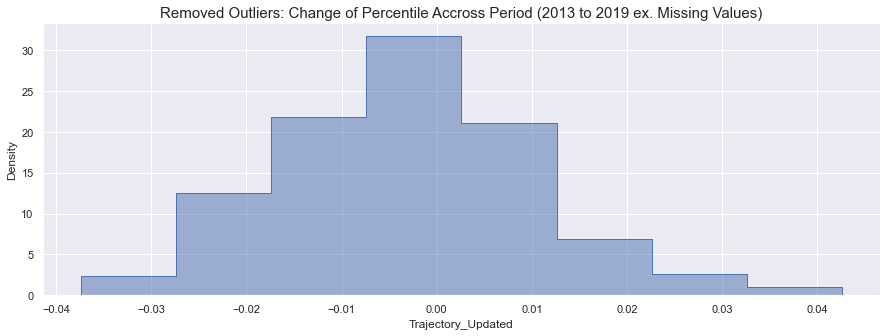

In [232]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=final_math_trajectory_df, x="Trajectory_Updated", stat='density',
                  binwidth=0.01, alpha=0.5, element="step"); # color=u'b'
plt.title("Neighborhoods: Change of Percentile Accross Period (2013 to 2019)", fontsize=15);

In [233]:
final_math_trajectory_df['Trajectory_Updated'].sort_values(ascending=False)

Borough        Neighborhood 
Bronx          Mount Eden       0.037872
Brooklyn       North Side       0.035727
               South Side       0.035727
Staten_Island  Old Town         0.032554
               South Beach      0.032554
                                  ...   
Queens         Woodhaven       -0.035726
               Corona          -0.037044
               Lefrak City     -0.037240
               Elmhurst        -0.037240
Brooklyn       Starrett City   -0.037389
Name: Trajectory_Updated, Length: 303, dtype: float64